<a href="https://colab.research.google.com/github/elizavetasemenova/PriorCVAE/blob/main/1dGP_n80_continuous_e400_b1K_PriorCVAE_PriorVAE_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Latent Gaussian process inference : MCMC-based method 

In [ ]:
!pip install numpyro

In [2]:
# general

import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
import math


# PyTorch

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.distributions as dist
from torch.distributions import Distribution
from torch.distributions.multivariate_normal import MultivariateNormal
#from tqdm import tqdm



# Numpyro

import numpyro
import numpyro.distributions as npdist
import random as rnd
from numpyro.infer import Predictive, init_to_median, init_to_feasible, MCMC, NUTS
from numpyro.diagnostics import hpdi


numpyro.set_host_device_count(4)


#JAX
import jax
from jax import random
import jax.numpy as jnp


# check versions

print(numpyro.__version__)
print(jax.__version__)
print(torch.__version__)
from platform import python_version
print(python_version())

0.16.1
0.4.35
2.4.0+cpu
3.10.14


In [3]:
# set device

torch.manual_seed(0)

if torch.cuda.is_available():

    torch.cuda.manual_seed(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [95]:
# Set a random seed for reproducibility
#np.random.seed()
# Define the number of observed points+
random_loc = []
size = 75
# Generate random arrays and add them to the list
random_array = np.random.choice(np.arange(150), size, replace=False)
random_loc.append(random_array)

In [96]:
#loc=[]
loc.append(random_array)

In [98]:
args = {

    "x_lim_low": 0,

    "x_lim_high":5,

    "input_dim":150, #50

    "obs_locations":random_loc, # [np.array([11,23, 39,50,61,72]),np.array([ 2, 11, 19, 27, 35, 43, 51, 59, 67, 75]),np.array([ 2, 12, 22, 32, 42, 52, 62, 72])],
    "target_ID": 0, # [0,1,2,3,4]  ( indices of observed locations)
    "key": 3, # key for reproductibility

        # MCMC setup

        "num_warmup":2000,

        "num_samples":[5000, 6000,10000],

        "num_chains": 2,

        "thinning": 1

       }

#args["x"], args["y_obs"], args["obs_idx"]
x = np.linspace(args["x_lim_low"],  args["x_lim_high"], args["input_dim"])
# target conditional 
ID=args[ "target_ID"]

## GP priors

In [99]:
def dist_euclid(x, z):

    x = jnp.array(x)

    z = jnp.array(z)

    if len(x.shape)==1:

        x = x.reshape(x.shape[0], 1)

    if len(z.shape)==1:

        z = z.reshape(z.shape[0], 1)

    n_x, m = x.shape

    n_z, m_z = z.shape

    assert m == m_z

    delta = jnp.zeros((n_x,n_z))

    for d in jnp.arange(m):

        x_d = x[:,d]

        z_d = z[:,d]

        delta += (x_d[:,jnp.newaxis] - z_d)**2

    return jnp.sqrt(delta)



def exp_sq_kernel(length, x, z, var,  noise=0, jitter=1.0e-5):

    dist = dist_euclid(x, z)

    deltaXsq = jnp.power(dist/ length, 2.0)

    k = var * jnp.exp(-0.5 * deltaXsq)

    k += (noise + jitter) * jnp.eye(x.shape[0])

    return k


# Inference

In [100]:
#@title Generate data

x=torch.tensor(x).type(torch.float32)

class CustomPrior(Distribution):

    def __init__(self, low, high,cov_func):

        super().__init__()

        self.dist1 = dist.Uniform(low=low, high=high) # prior over lenghtscale

        #self.dist2 = dist.HalfNormal(scale)

        self.cov_func = cov_func  # Function to compute covariance matrix



    def sample(self, sample_shape=torch.Size()):

        sample1 = self.dist1.sample(sample_shape) # ls

        #sample2 = self.dist2.sample(sample_shape) # epsilon

        # Calculate covariance matrix using the sample from dist1

        if sample1.dim()==0:

          K= self.cov_func(ls=sample1)

          dist3 = dist.MultivariateNormal(loc=torch.zeros(K.shape[0]), covariance_matrix=K)

          sample3=dist3.sample()

          samples=sample3

        else:

          sample_list=[]

          for ls in sample1:

            K= self.cov_func(ls=ls)   #GP_kernel

            # Create dist3 using the calculated covariance matrix

            dist3 = dist.MultivariateNormal(loc=torch.zeros(K.shape[0]), covariance_matrix=K)

          # Sample from dist3

            sample_list.append(dist3.sample())

          # combine sample

          sample3= torch.stack(sample_list)



            # Concatenate sample1, sample2, and sample3 along the last dimension

          samples = sample3

        return samples



    def log_prob(self):

        pass



def dist_euclid_torch(x, z):

    x = torch.as_tensor(x)

    z = torch.as_tensor(z)

    if len(x.shape) == 1:

        x = x.unsqueeze(1)

    if len(z.shape) == 1:

        z = z.unsqueeze(1)

    n_x, m = x.shape

    n_z, m_z = z.shape

    assert m == m_z

    delta = torch.zeros((n_x, n_z))

    for d in range(m):

        x_d = x[:, d]

        z_d = z[:, d]

        delta += (x_d[:, None] - z_d) ** 2

    return torch.sqrt(delta)



def gp_kernel(ls ,x=x, z=x,sigma=1, noise=0, jitter=1.0e-5):

    dist = dist_euclid_torch(x, z)

    deltaXsq = torch.pow(dist / ls, 2.0)

    k = (sigma ** 2) * torch.exp(-0.5 * deltaXsq)

    k += (noise + jitter) * torch.eye(x.shape[0], device=x.device)

    return k



### define the prior and the Model simulator model



## GP priors with RBF kernel

prior=CustomPrior(low=0.1, high=0.2, cov_func=gp_kernel)



## GP priors with Matern kernel

#K = matern_kernel(ls=length_scale)

#mean = torch.zeros(N)  # Zero mean

#prior2= MultivariateNormal(mean, covariance_matrix=cov_matrix)



## Likelihood

def likelihood(theta):

  epsilon=dist.HalfNormal(0.3).sample()

  if theta.dim()==1:

    f_gp=theta                             #[np.array(obs_idx)]

  else:

    f_gp=(theta[:,:]).squeeze()             #np.array(obs_idx)



  mean,cov=f_gp,(epsilon**2)*torch.eye(len(f_gp))

  y=dist.MultivariateNormal(mean,cov).sample()

  # y= f_gp + epsilon*torch.randn_like(f_gp)

  return y.unsqueeze(0)




def play_simul(prior,simulator,obs_idx_lst=args["obs_locations"],idx=0,title="1D GP with RBF Kernel"):

  plt.figure(figsize=(5,4))

  if idx<len(obs_idx_lst):

      x_obs = x[np.array(obs_idx_lst[idx])]

      y_obs=simulator(prior).squeeze().numpy()

      plt.plot(x.numpy(),prior.numpy(),label="ground truth", color="red")

      plt.scatter(x_obs,y_obs[obs_idx_lst[idx]], color="green", label="observed", s=60)

      plt.title(title)

      plt.legend()

      plt.show()

      y_observations=[]

      for i in range(len(obs_idx_lst)):

            y_observations.append(y_obs[obs_idx_lst[i]])

      return y_observations

/opt/conda/lib/python3.10/site-packages/torch/distributions/distribution.py:55: UserWarning: <class '__main__.CustomPrior'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


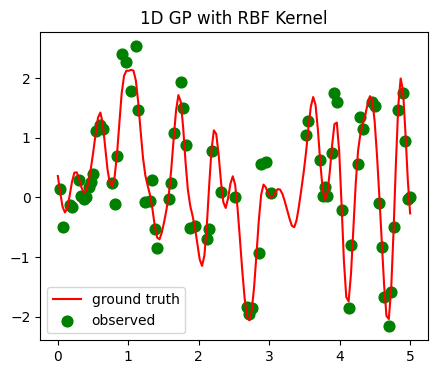

In [102]:
torch.manual_seed(args["key"])

p=prior.sample()    # GP-based RBF Kernel

y_true=p

y_observations = play_simul(p,likelihood,idx=ID) # outcomes associated to set of sparsed locations
args["y_obs"], args["obs_idx"]=y_observations[ID],args["obs_locations"][ID]

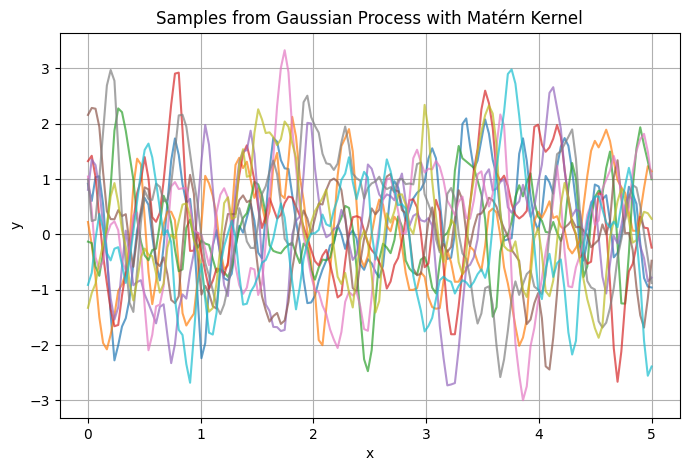

In [103]:
import jax
from jax import jit
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax.random import multivariate_normal

#@title Matérn kernel function 
def matern_kernel(ls=0.1, x=jnp.array(x), z=jnp.array(x), variance=1.0, nu=2.5, jitter=1.0e-6):
    X, Z = x[:, None], z[:, None]
    distance = jnp.linalg.norm(X[:, None, :] - Z[None, :, :], axis=-1)
    if nu == 0.5:
        K = jnp.exp(-distance / ls)
    elif nu == 1.5:
        sqrt_3 = jnp.sqrt(3)
        term = sqrt_3 * distance / ls
        K = (1.0 + term) * jnp.exp(-term)
    elif nu == 2.5:
        sqrt_5 = jnp.sqrt(5)
        term = sqrt_5 * distance / ls
        K = (1.0 + term + (term ** 2) / 3.0) * jnp.exp(-term)
    else:
        raise NotImplementedError("Matérn kernel with arbitrary nu is not implemented.")
    K = K + jitter * jnp.eye(K.shape[0])  # Add jitter for numerical stability
    return variance * K
    

# Generate 10 samples from the GP
key = random.PRNGKey(0)
n_samples = 10
kernel_matrix = matern_kernel(ls=0.1)

# Sample from the GP
samples = random.multivariate_normal(key, mean=jnp.zeros(len(x)), cov=kernel_matrix, shape=(n_samples,))

# Plot the samples
plt.figure(figsize=(8, 5))
for i in range(n_samples):
    plt.plot(x, samples[i], label=f'Sample {i+1}', alpha=0.7)
plt.title('Samples from Gaussian Process with Matérn Kernel')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

## Numpyro GP model

In [104]:


def GP_model(x, y=None, obs_idx=None,length=None, jitter=1e-5, var=1.0, gp_kernel=matern_kernel): 
    #, gp_kernel=exp_sq_kernel
    #if length==None:
    length = numpyro.sample("length", npdist.Uniform(0.01,1))

    k = gp_kernel(length,x,x,var)

    sigma = numpyro.sample("noise", npdist.HalfNormal(0.1))

    f = numpyro.sample("f", npdist.MultivariateNormal(loc=jnp.zeros(x.shape[0]), covariance_matrix=k))


    if y is None: # durinig prediction

        y_pred = numpyro.sample("y_pred", npdist.Normal(f, sigma))



    else: # during inference

        y = numpyro.sample("y", npdist.Normal(f[obs_idx], sigma), obs=y)

In [105]:
def run_mcmc_GP(rng_key, GP_model, args,verbose=True, length=None, idx=0):

    start = time.time()

    #init_strategy = init_to_median(num_samples=10)

    init_strategy = init_to_feasible()

    kernel = NUTS(GP_model, init_strategy=init_strategy)

    mcmc = MCMC(

        kernel,

        num_warmup=args["num_warmup"],

        num_samples=args["num_samples"][idx],

        num_chains=args["num_chains"],

        thinning=args["thinning"],

        progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True,
       )
    
    mcmc.run(rng_key, jnp.array(x), args["y_obs"], args["obs_idx"], length )

    if verbose:

        mcmc.print_summary(exclude_deterministic=False)


    ss = numpyro.diagnostics.summary(mcmc.get_samples(group_by_chain=True))

    r = np.mean(ss['f']['n_eff'])

    print("Average ESS for all GP effects : " + str(round(r)))

    return (mcmc,mcmc.get_samples())

In [ ]:

rng_key =  random.PRNGKey(1)
rng_key, rng_key_prior, rng_key_post, rng_key_pred = random.split(rng_key, 4)

import time    
start=time.time()
mcmc_GP, mcmc_GP_samples = run_mcmc_GP(rng_key_post, GP_model, args,True, None,0)
end=time.time()
print("Total elapsed time (10 obseced):", round(end - start), "sec")


  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

In [93]:
#run_times=[] #1268                    (1220,4240*2 sec,7h,)
run_times.append(round(end - start)) #[50,100,150)

In [40]:
# #exp_results_100pts=[] # list (mcmc_model, samples, elapsed time)
# rng_key =  random.PRNGKey(1)

# rng_key, rng_key_prior, rng_key_post, rng_key_pred = random.split(rng_key, 4)

# for i in range(len(args["num_samples"])):
    
#     start=time.time()
#     mcmc_GP, mcmc_GP_samples = run_mcmc_GP(rng_key_post, GP_model, args,True, None,i)
#     end=time.time()
#     exp_results_100pts.append(( mcmc_GP, mcmc_GP_samples,round(end - start)))
#     #

In [ ]:
# import pickle
# with open('experiments_results.pkl', 'wb') as f:
#      pickle.dump(exp_results, f)

In [32]:
#@title plotter

def median_pred(samples,y_true,x_obs,y_obs,title="MCMC-based GP inference",labels=False,draws=False,n=10):

  "samples (Array): (batch,vector_dim)"

  predictions=np.array(samples)

  #plot

  mean_post_pred = np.median(predictions, axis=0)

  #hpdi_post_pred = hpdi(predictions, 0.9)

  percentiles = np.percentile(predictions, [5.0, 95.0], axis=0)

  plt.plot(x, np.array(y_true), label="ground truth ", color="orange")

  plt.scatter(x_obs, np.array(y_obs), color="red", label="{} observed".format(len(y_obs)), s=40)

  plt.plot(x, mean_post_pred, label="predicted mean",alpha=1)

  #plt.plot(x.numpy(), mean_post_pred, label="predicted mean")

  plt.fill_between(x, percentiles[0, :], percentiles[1, :], alpha=0.5, interpolate=True, label="posterior: 95% BCI")

  if draws==True:

        # Randomly select 'n' row vectors and plot them

    selected_indices = np.random.choice(predictions.shape[0], n, replace=False)

    for i, idx in enumerate(selected_indices):

        if i == 0:

              # Add label only for the first line

            plt.plot(x, predictions[idx], color="darkgreen", alpha=0.3, label="Posterior draws")

        else:

              # No label for the remaining lines

            plt.plot(x, predictions[idx], color="darkgreen", alpha=0.3)



  plt.xlim([0, 5])

  #plt.xticks([])  # Removes x-axis ticks

  plt.yticks([])  # Removes y-axis ticks

  if title!=None:

    plt.title(title)

  if labels==True:

      plt.xlabel('x')

      plt.ylabel('f(x)')

  #plt.legend()

  #plt.tight_layout()  # Adjust layout to fit everything nicely

  plt.legend(fontsize=7)


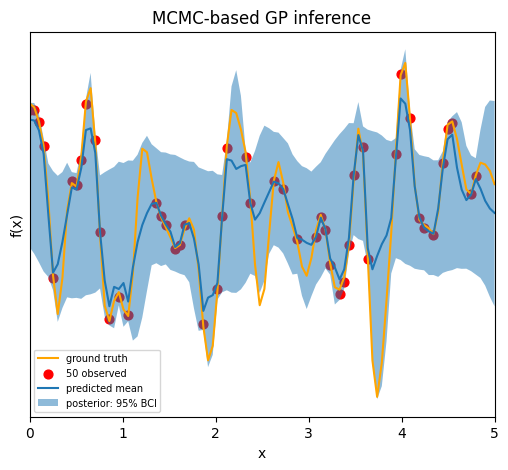

In [94]:
args['x_obs']=np.array(x[args["obs_idx"]])
predictive = Predictive(GP_model, mcmc_GP_samples)

predictions_gp= predictive(rng_key_pred, jnp.array(x), None, args["obs_idx"], length=None)['y_pred']

fig=plt.figure(plt.figure(figsize=(6,5)))
median_pred(predictions_gp,np.array(y_true),args['x_obs'],args['y_obs'],labels=True,draws=False,n=20)

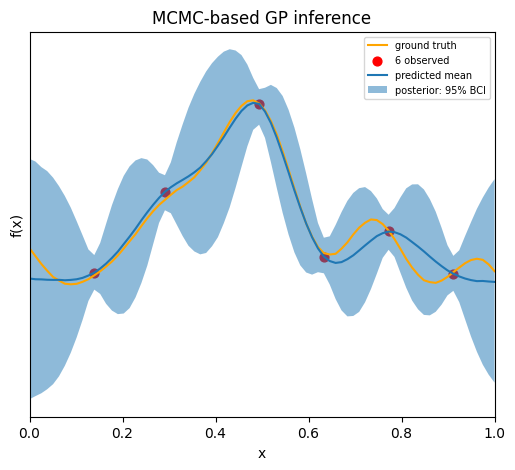

In [42]:
# predictive = Predictive(GP_model, mcmc_GP_samples)

# predictions_gp= predictive(rng_key_pred, x, None, args["obs_idx"], length=None)['y_pred']

# fig=plt.figure(plt.figure(figsize=(6,5)))
# median_pred(predictions_gp,np.array(y_true),args['x_obs'],args['y_obs'],labels=True,draws=False,n=20)

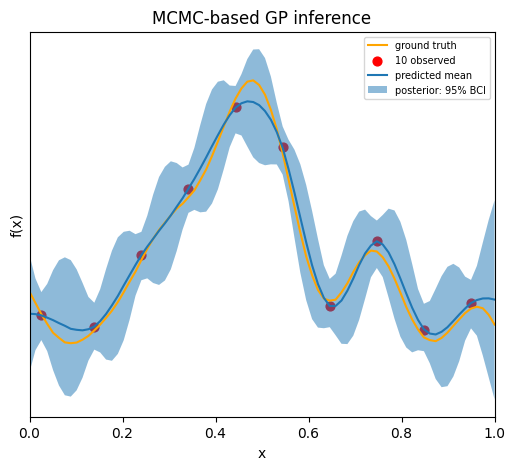

In [19]:
# predictive = Predictive(GP_model, mcmc_GP_samples)

# predictions_gp= predictive(rng_key_pred, x, None, args["obs_idx"], length=None)['y_pred']

# fig=plt.figure(plt.figure(figsize=(6,5)))
# median_pred(predictions_gp,np.array(y_true),args['x_obs'],args['y_obs'],labels=True,draws=False,n=20)

In [46]:
# import pickle
# with open('MCMC_samples.pkl', 'wb') as f:
#      pickle.dump(MCMC_samples, f)

# with open('mcmc_GP_6pts_post_pred_samples.pkl', 'wb') as f:
#     pickle.dump( predictions_gp, f)
    
# np.save('mcmc_GP_6pts_post_pred_samples.pkl.npy', predictions_gp)
# fig.savefig('mcmc_GP_6pts.eps')
# fig.savefig('mcmc_GP_6pts.pdf')